<center> In the name of God <center>

# <center> Sharif University of Technology <center> Department of Economics <center>
# <center> Quantitative Economics - Spring 2022 <center>Problem Set 12<center>

##  <center> Team Members <center>
<center> - Niloofar Moradi <center>- Mohamad R. Manzaritavakoli <center>

# 1 Numerical Methods tests

## 1. Now use your Value Function Iteration class written the previous problem sets and solve the above Bellman equation numerically. 

$$
\begin{gathered}
V(y)=\max _{c}\left\{U(c)+\beta E\left[V\left(\xi(y-c)^{\alpha}\right)\right]\right\} \\
U(c)=ln(c) \\
log (\xi) {\sim} N(0, \sigma)
\end{gathered}
$$

In [ ]:
using Distributions, Plots, Optim, Interpolations, Random, Plots.PlotMeasures, BenchmarkTools, Flux, LinearAlgebra;

In [ ]:
using QuantEcon;

In [19]:
Plots.theme(:juno)

In [13]:
#set parameters:
α = 1/3
σ = 0.01
β = 0.93
N = 100
ϵ= 10^(-2);

In [14]:
#generate shocks
Random.seed!(1394)
ζ = rand(LogNormal(0, σ), 10000)
A = mean(ζ);

We assume there is no shock in order to calculate parameters at steady state:

The problem is:
$$
W=Max\sum_{t=0}^{\infty} \beta^{t} u\left(c_{t}\right)
$$

Subject to: $$C_{t}+I_t =A_t F(K_t)$$
$$ K_{t+1}=I_t$$

Lagrangian:
$$\mathcal{L}=\sum_{t=0}^{\infty} \beta^{t} u\left(c_{t}\right)+\sum_{t=0}^{\infty} \lambda_{t} (A_t f(K_t)-c_t-K_{t+1})) $$

FOCs:
$$ 
[c_t]: \beta U'(c_t) =\lambda _t
$$
$$
[K_{t+1}]:\lambda _t=\lambda _{t+1}(A_{t+1}F'(K_{t+1}))
$$
$$
[\lambda_{t}]:c_t+ K_{t+1}=A_{t}F(K_{t})
$$

Steady state:
$$
c_t=c_{t+1}=\bar{c}
$$
$$
K_t=K_{t+1}=\bar{K}
$$

$$ \rightarrow 1=\beta (AF'(\bar{K})) \rightarrow \bar{K}=(\frac {1}{\beta A \alpha})^{\frac {1}{\alpha -1}}
$$ 

$$ \rightarrow \bar{y}=A {\bar{K}}^{\alpha}=A(\frac {1}{\beta A \alpha})^{\frac {\alpha}{\alpha -1}}=A^{\frac{1}{1-\alpha}}({\beta  \alpha})^{\frac {\alpha}{1- \alpha }}
$$ 

In [11]:
#the method is value function iteration
function VFI(r, # utility function
            h, # productivity function
            shock_distribution, # the distribution of shocks
            y_star, # y in steady state
            N, # nunmber of iterations
            R, # number of grids and shocks
            β) # discount factor
    Random.seed!(1394)
    ζ = rand(shock_distribution, R) # generate shocks
    A = mean(ζ)
    ygrid = range(0.001, y_star*1.2, R) 
    Initial_V(y) = y # set initial guess generator function
    V₀ = Initial_V.(ygrid)
    Vⱼ = V₀
    Policy = zeros(R)
    Vⱼ₊₁ = zeros(R)
    g = zeros(R)
    for itr ∈ 1:N
        V = LinearInterpolation(ygrid, Vⱼ[:,end], extrapolation_bc = Line())
        for i ∈ 1:R
            y = ygrid[i]
            Ω(c) = -(r(c) + β*mean(V(ζ .* h(y, c))))
            opt = optimize(Ω, 0, y)
            g[i] = opt.minimizer
            Vⱼ₊₁[i] = -Ω(g[i])
        end
        Vⱼ = hcat(Vⱼ, Vⱼ₊₁)
        Vⱼ₊₁ = zeros(R)
    end
    return Vⱼ, g
end

VFI (generic function with 1 method)

In [15]:
r(u) = log(u)
h(x, u) = (x - u)^α
y_star = (β*α)^((α)/(1-α))*A^((1)/(1 - α))

0.5568584711379513

In [ ]:
V, policy = VFI(r, h, LogNormal(0, σ), y_star, 100000, 200, β)

Plotting all value functions that has been generated in each iteration.

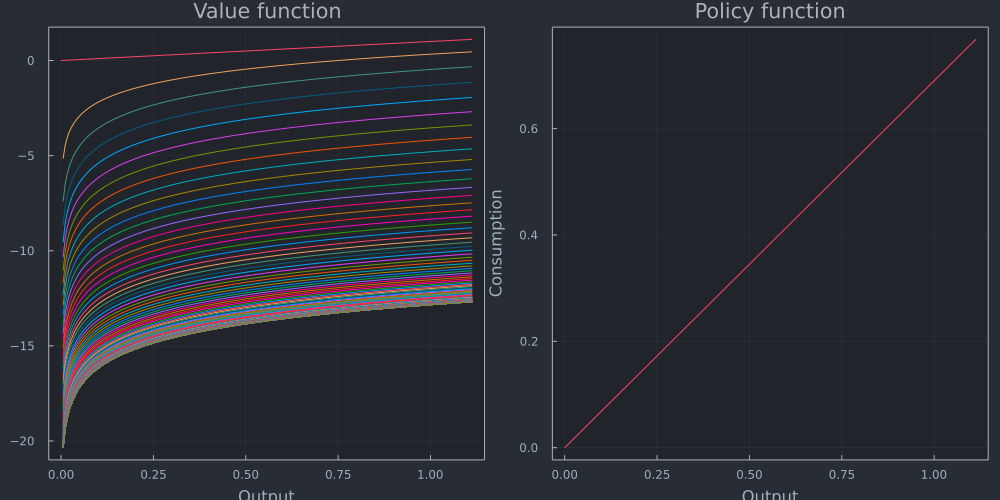

In [9]:
plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(range(0.0, y_star*2, 200), V, title = "Value function", label = false, xlabel = "Output")
push!(plots, p1)
p2 = plot(range(0.0, y_star*2, 200), policy, title = "Policy function", label = false, ylabel = "Consumption", xlabel = "Output")
push!(plots, p2)
plot(plots..., framestyle = :box)

Plotting the value functions that has been obtained after 1, 10, 100, 1000 and 10000 iterations.

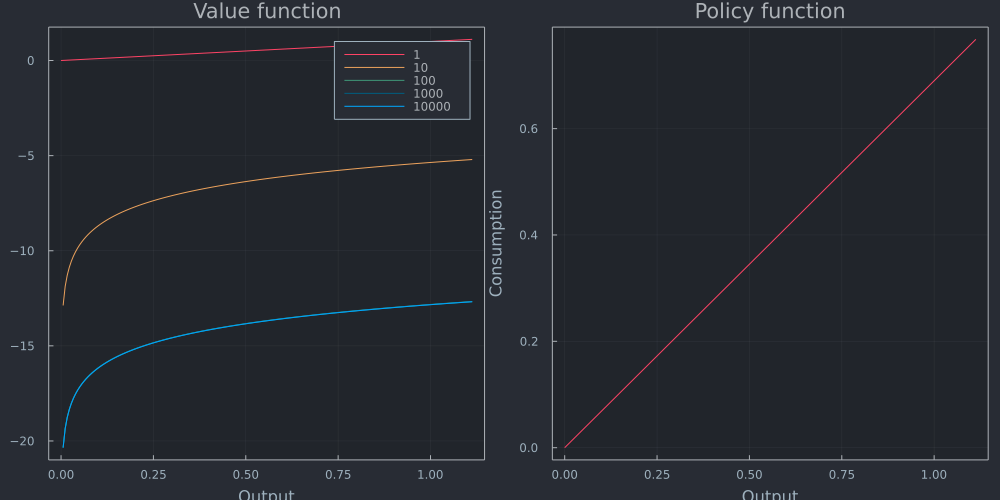

In [21]:
V₀ = [V[:, 1], V[:, 10], V[:, 100], V[:, 1000], V[:, 10000]];
plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(range(0.0, y_star*2, 200), V₀, title = "Value function", label = ["1" "10" "100" "1000" "10000"], xlabel = "Output")
push!(plots, p1)
p2 = plot(range(0.0, y_star*2, 200), policy, title = "Policy function", label = false, ylabel = "Consumption", xlabel = "Output")
push!(plots, p2)
plot(plots..., framestyle = :box)

We can see that for N = 100, 1000 and 10000, the value functions are almost same.

توابع زیر برای بدست آوردن حل های آنالتیکال هستند:

In [4]:
function policy_star(y, α, β)
    """
    True optimal policy
    """
    return (1 - α * β) * y
end

policy_star (generic function with 1 method)

In [5]:
function v_star(y, α , β, μ)
    """
    True value function
    """
    c1 = log(1 - α * β) / (1 - β)
    c2 = (μ + α *log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * log(y)
end

v_star (generic function with 1 method)

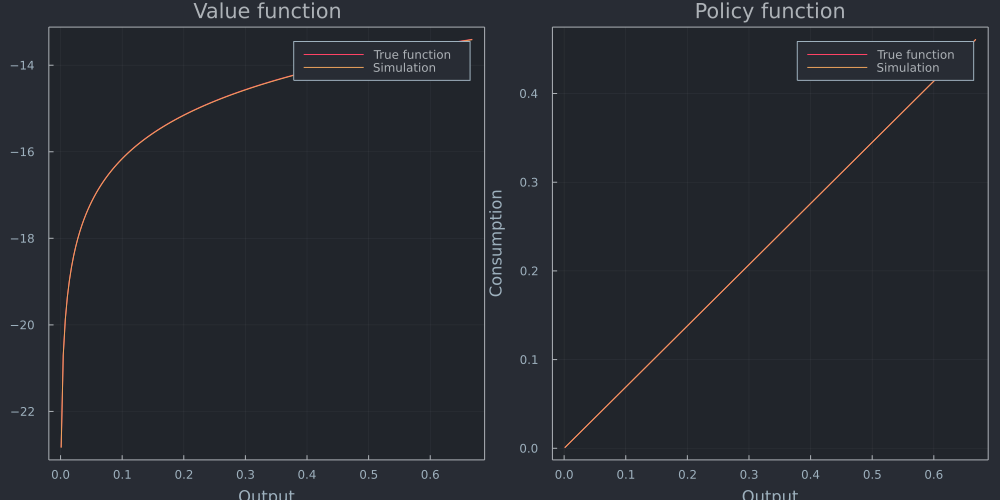

In [20]:
ygrid = range(0.001, y_star*1.2, 200)
policy_true = policy_star.(ygrid, α, β)
value_true = v_star.(ygrid, α , β, 0)
plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(ygrid, value_true, title = "Value function", label = "True function", xlabel = "Output")
p1 = plot!(ygrid, V[:, end], title = "Value function", label = "Simulation", xlabel = "Output")
push!(plots, p1)
p2 = plot(ygrid, policy_true, title = "Policy function", label = "True function", ylabel = "Consumption", xlabel = "Output")
p2 = plot!(ygrid, policy , title = "Policy function", label = "Simulation", ylabel = "Consumption", xlabel = "Output")
push!(plots, p2)
plot(plots..., framestyle = :box)

مشاهده می کنیم که نتایج ما برای روش ولیو فانکشن ایتریشن دقیقا مطابق بر نتاج بدست آمده برای حل آنالیتیکال است.

## 2. Now use your Policy Function Iteration Class to do the same tasks. Which method converges faster?

In [21]:
r(x, u) = log(u)
g(x, u) = (x - u)^α
ru(x, u) = 1/u
rx(x, u) = 0 
gu(x, u) = -α*(x-u)^(α-1)
gx(x, u) = α*(x-u)^(α-1)

gx (generic function with 1 method)

In [22]:
function PFI(r, # utility function
            h, # productivity function
            ru,
            rx,
            hu,
            hx,
            shock_distribution, # the distribution of shocks
            y_star, # y in steady state
            N, # nunmber of iterations
            R, # number of grids and shocks
            β) # discount factor
    Random.seed!(1394)
    ζ = rand(shock_distribution, R) # generate shocks
    A = mean(ζ)
    ygrid = range(0.001, y_star*2, R) 
    policies = zeros(R)
    V′ⱼ = collect(ygrid)
    c_g = zeros(R)
    V′ⱼ₊₁ = zeros(R)
    for itr ∈ 1:N
        V_intp = LinearInterpolation(ygrid, V′ⱼ, extrapolation_bc = Line())
        for i ∈ 1:R
            y = ygrid[i]
            G(c) = (ru(y, c) + β * mean(ζ.*hu(y, c) .* V_intp.(ζ.*h(y, c) )) )^2
            c_g[i] = optimize(G, 0.0, y).minimizer #FOC
        end
        policies = hcat(policies, c_g)
        for i ∈ 1:R
            c = policies[:, end][i]
            y = ygrid[i]
            V′ⱼ₊₁[i] = β* mean(ζ.*hx(y, c) .* V_intp.(ζ.* h(y, c))) #EC
        end
        V′ⱼ = V′ⱼ₊₁
        c_g = zeros(R)
    end
    return policies, LinearInterpolation(ygrid, policies[:, end], extrapolation_bc = Line())
end

PFI (generic function with 1 method)

In [ ]:
policies, policy_function = PFI(r, # utility function
            g, # productivity function
            ru,
            rx,
            gu,
            gx,
            LogNormal(0, σ), # the distribution of shocks
            y_star, # y in steady state
            10000, # nunmber of iterations
            100, # number of grids and shocks
            β)

In [14]:
h₀ = [policies[:, 1], policies[:, 10], policies[:, 100], policies[:, 1000], policies[:, 10000]];

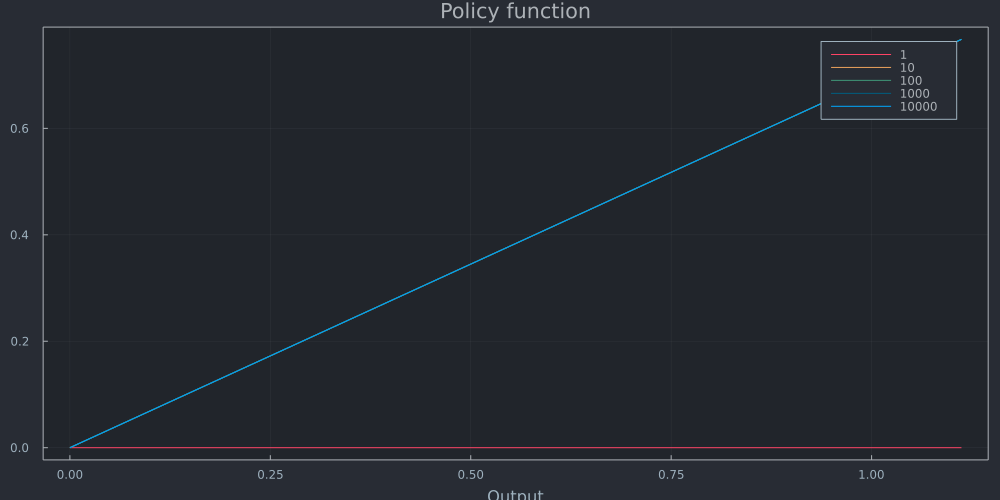

In [16]:
plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(range(0.0, y_star*2, 100), h₀, title = "Policy function", label = ["1" "10" "100" "1000" "10000"], xlabel = "Output")
push!(plots, p1)
# p2 = plot(range(0.0, y_star*2, 200), policy, title = "Policy function", label = false, ylabel = "Consumption", xlabel = "Output")
# push!(plots, p2)
plot(plots..., framestyle = :box)

از لحاظ سرعت کانورج کردن پالیسی فانکشن ایتریشن یک متد بهتر است و با تعداد تکرار کمتر به نتیجه میرسد. اما الگوریتم به صورتی است که تعداد بیشتری اپتیمایزر داریم و اینورس چند تابع باید گرفته شود که سرعت الگوریتم را کمتر میکند نسبت به تکرار ولیو فانکشن. 

In [23]:
@btime PFI(r, # utility function
            g, # productivity function
            ru,
            rx,
            gu,
            gx,
            LogNormal(0, σ), # the distribution of shocks
            y_star, # y in steady state
            100, # nunmber of iterations
            100, # number of grids and shocks
            β);

  3.450 s (8385346 allocations: 322.69 MiB)


In [26]:
@btime VFI(r, h, LogNormal(0, σ), y_star, 100, 100, β);

  3.372 s (10479290 allocations: 536.99 MiB)


## 3 Plot the policy function for three different values of the variance of the shock (vary the distribution parameters).

In [7]:
r(u) = log(u)
h(x, u) = (x - u)^α
a = 1
b = 2.5
A = b*a/(b - 1)
y_star = (β*α)^((α)/(1-α))*A^((1)/(1 - α))
V, policy = VFI(r, h, Pareto(b, a), y_star, 1000, 100, β);

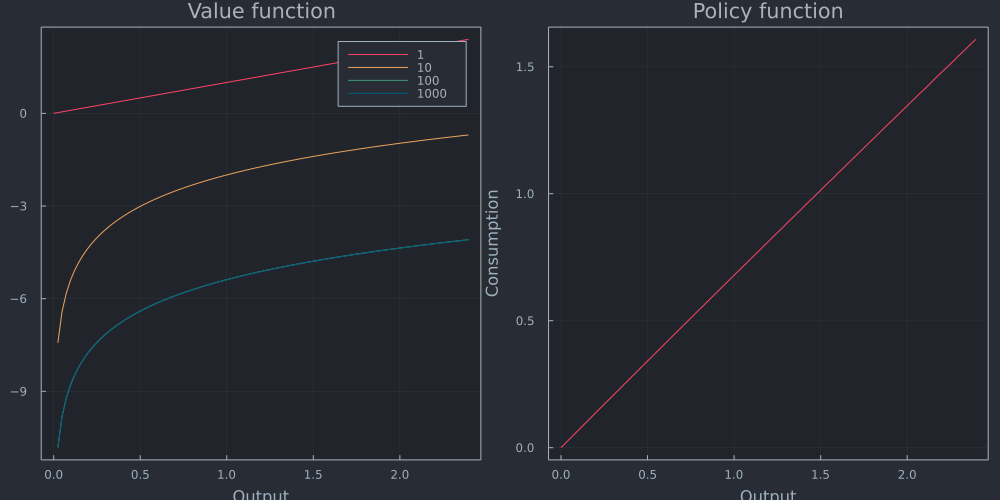

In [8]:
V₀ = [V[:, 1], V[:, 10], V[:, 100], V[:, 1000]];
plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(range(0.0, y_star*2, 100), V₀, title = "Value function", label = ["1" "10" "100" "1000" "10000"], xlabel = "Output")
push!(plots, p1)
p2 = plot(range(0.0, y_star*2, 100), policy, title = "Policy function", label = false, ylabel = "Consumption", xlabel = "Output")
push!(plots, p2)
plot(plots..., framestyle = :box)

Policy function with different variances for shocks:

In [129]:
using Roots

In [10]:
h1 = VFI(r, h, LogNormal(0, 0.01), y_star, 100, 100, β)[2]
h2 = VFI(r, h, LogNormal(0, 1), y_star, 100, 100, β)[2]
h3 = VFI(r, h, LogNormal(0, 5), y_star, 100, 100, β)[2];

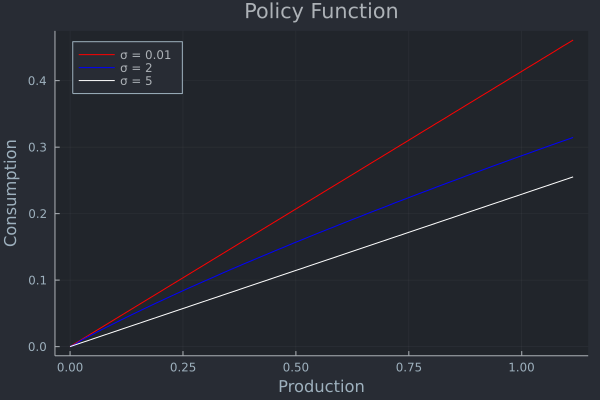

In [12]:
p1 = plot(range(0.0, y_star*2, 100), h1, label = "σ = 0.01", title = "Policy Function", color = "red", ylabel = "Consumption", xlabel = "Production")
p1 = plot!(range(0.0, y_star*2, 100), h2, label = "σ = 2", color = "blue")
p1 = plot!(range(0.0, y_star*2, 100), h3, label = "σ = 5", color = "white")
plot(p1, layout = (1, 1), size = (600, 400), legend = :topleft)

بیشتر شدن واریانس یعنی بیشتر شدن ریسک. فرد مورد نظر با توجه به تابع مطلوبیتی که دارد ریسک گریز است و طبیعی است بیشتر شدن ریسک باعث کمتر شدن مطلوبیت آن شود. از طرفی شاهد پری کاشنری سیوینگ هم هستیم و در هر مرحله که واریانس بیشتر شده است مصرف کاهش پیدا کرده و است و سرمایه گذاری بیشتر شده است. نمودار پالیسی ما این موضوع را تایید می کند.

# 2 Consumption Saving


###  a, s setting

In [34]:
function VFI_1(r, σ, ω, β, N, R, U, s_dist, tol)
    a_max = 5.
    a_min = 0.
    agrid = collect(range(a_min, a_max, length = N))
    Random.seed!(1394)
    sgrid = rand(s_dist, R)

    Γ(a, s) = min((1 + r)*a + ω*s, a_max)

    V₀ = zeros(N, R)
    dist = 1
    aprime = zeros(N, R)
    V₁ = zeros(N, R)

    function ExpectedValue(a) # get the expected values of all possible future shocks
        result = []
        for s ∈ 1:R
            V_intp = LinearInterpolation(agrid, V₀[:, s])
            append!(result, V_intp(a))
        end
        return mean(result)
    end

    while dist > tol
        for s ∈ 1:R
            
            for i ∈ 1:N
                Ω(a′) = -(U(agrid[i], a′, sgrid[s]) + β * ExpectedValue(a′))
                aprime[i, s] = optimize(Ω, 0.0, Γ(agrid[i], sgrid[s])).minimizer
                V₁[i, s] = -Ω(aprime[i, s])
            end
        end
        dist = maximum([maximum(abs.(V₁[:, s] .- V₀[:, s])) for s ∈ 1:R])
        V₀ = V₁
        V₁ = zeros(N, R)
    end

    return V₀, aprime, agrid, sgrid
end

VFI_1 (generic function with 1 method)

In [35]:
U(a, a′, s) = log((1 + rr)*a + ω*s - a′)

U (generic function with 1 method)

In [ ]:
rr = 0.1
ω = 1
β = 0.93
N = 100
tol = 10^-1
R = 100
U(a, a′, s) = log((1 + rr)*a + ω*s - a′)
V₀, aprime, agrid, sgrid = VFI_1(rr, σ, ω, β, 100, 10, U, Uniform(0, 1), tol)

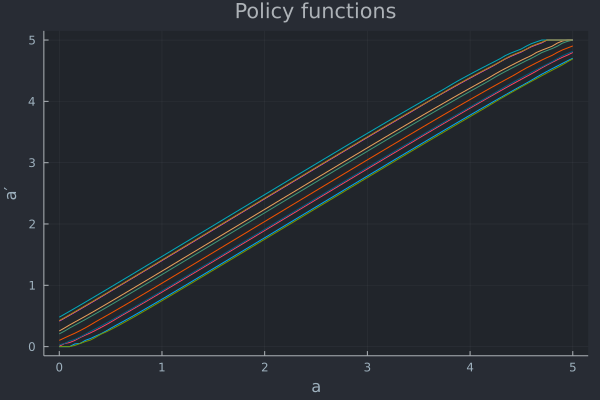

In [77]:
plot(agrid, aprime, xlabel = "a" , ylabel = "a′" , title = "Policy functions" , label = false)

## 2. Plot the policy and value functions for m = 1; 2; 3. How do results depend on the variance m?


In [9]:
function mvar_to_ab(m, σ)
    b = √3 * σ + m
    a = 2*m - b
    return a, b
end

mvar_to_ab (generic function with 1 method)

In [ ]:
m = 1
σ = 0.5
a, b = mvar_to_ab(m, σ)
V₀1, aprime1, agrid1, sgrid1 = VFI_1(rr, σ, ω, 0.85, 100, 10, U, Uniform(a, b), tol)

In [ ]:
m = 2
σ = 0.5
a, b = mvar_to_ab(m, σ)
V₀2, aprime2, agrid2, sgrid2 = VFI_1(rr, σ, ω, β, 100, 10, U, Uniform(a, b), tol)

In [ ]:
m = 3
σ = 0.5
a, b = mvar_to_ab(m, σ)
V₀3, aprime3, agrid3, sgrid3 = VFI_1(rr, σ, ω, β, 100, 10, U, Uniform(a, b), tol)

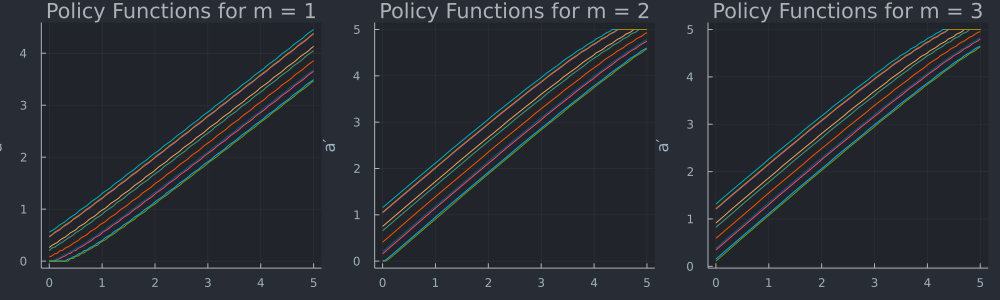

In [39]:
p1 = plot(agrid1, aprime1, xlabel = "a" , ylabel = "a′" , label = false)
p2 = plot(agrid2, aprime2, xlabel = "a" , ylabel = "a′" , label = false)
p3 = plot(agrid3, aprime3, xlabel = "a" , ylabel = "a′" , label = false)
plot(p1, p2, p3, layout = (1, 3), size = (1000, 300), title= ["Policy Functions for m = 1" "Policy Functions for m = 2" "Policy Functions for m = 3"])

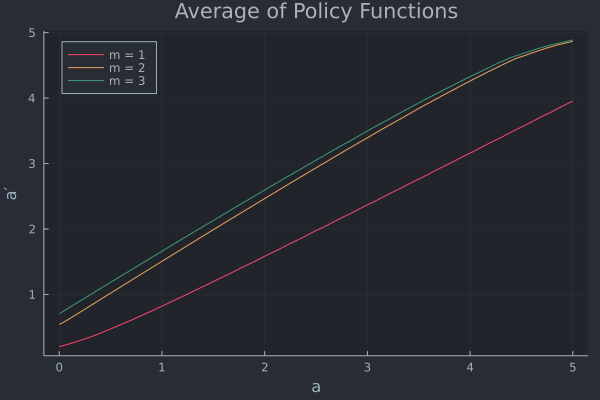

In [40]:
p1 = plot(agrid1, mean(aprime1, dims = 2), label = "m = 1", ylabel = "a′", xlabel = "a")
p1 = plot!(agrid2, mean(aprime2, dims = 2), label = "m = 2", ylabel = "a′", xlabel = "a")
p1 = plot!(agrid3, mean(aprime3, dims = 2), label = "m = 3", ylabel = "a′", xlabel = "a")
plot(p1, layout = (1, 1), size = (600, 400), title= "Average of Policy Functions", legend = :topleft)

با بیشتر شدن میانگین توزیع شوک به عبارتی انتظار داریم که اطمینان ما از شرایط دوره بعد بالاتر رود و وضعیت خوبی داشته باشیم. پس در این دوره با بیشتر شدن ام انتظار داریم سرمایه گذاری ما کمتر شود. البته این موضوع از طرفی وابسته به این است که کل سطح تولید ما چقدر بیشتر شده است. به عبارتی بیشتر شدن تولید می تواند درصد پس انداز ما را کاهش دهد ولی مقدار ابسولوت آن را افزایش دهد. پس مشاهده کردن هر دو سری نتایج ممکن است و در این بخش ما بر اساس پارامتر های خود نتیجه دوم را دیده ایم در حالی ک در بخش بعدی دقیقا نتیجه اول تایید شده است.

## 3. Plot the policy and value functions for $\sigma  = .1; .2; .3 $. How do results depend on the variance ? Explain in terms of the precautionary saving. Do we observe it here?

In [41]:
m = 1
σ = 0.1
a, b = mvar_to_ab(m, σ)
V₀4, aprime4, agrid4, sgrid4 = VFI_1(rr, σ, ω, 0.85, 100, 10, U, Uniform(a, b), tol);

In [42]:
m = 1
σ = 0.5
a, b = mvar_to_ab(m, σ)
V₀5, aprime5, agrid5, sgrid5 = VFI_1(rr, σ, ω, 0.85, 100, 10, U, Uniform(a, b), tol);

In [ ]:
m = 1
σ = 0.6
a, b = mvar_to_ab(m, σ)
V₀6, aprime6, agrid6, sgrid6 = VFI_1(rr, σ, ω, 0.85, 100, 10, U, Uniform(a, b), tol)

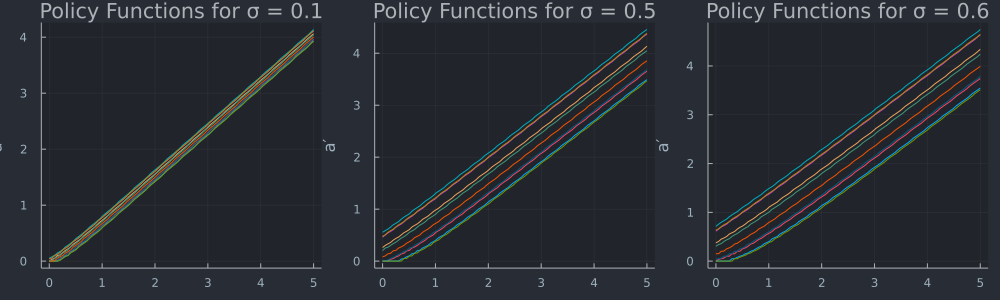

In [45]:
p1 = plot(agrid4, aprime4, xlabel = "a" , ylabel = "a′" , label = false)
p2 = plot(agrid5, aprime5, xlabel = "a" , ylabel = "a′" , label = false)
p3 = plot(agrid6, aprime6, xlabel = "a" , ylabel = "a′" , label = false)
plot(p1, p2, p3, layout = (1, 3), size = (1000, 300), title= ["Policy Functions for σ = 0.1" "Policy Functions for σ = 0.5" "Policy Functions for σ = 0.6"])

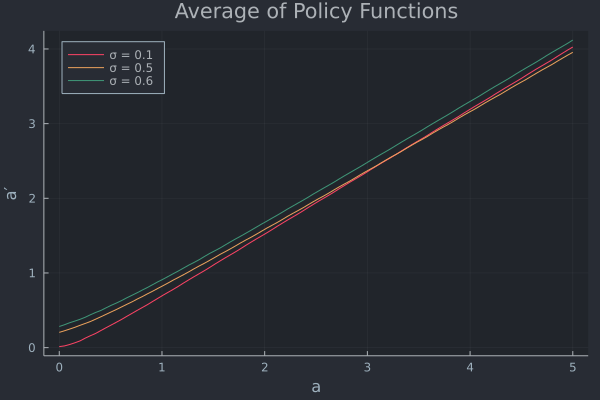

In [46]:
p1 = plot(agrid4, mean(aprime4, dims = 2), label = "σ = 0.1", ylabel = "a′", xlabel = "a")
p1 = plot!(agrid5, mean(aprime5, dims = 2), label = "σ = 0.5", ylabel = "a′", xlabel = "a")
p1 = plot!(agrid6, mean(aprime6, dims = 2), label = "σ = 0.6", ylabel = "a′", xlabel = "a")
plot(p1, layout = (1, 1), size = (600, 400), title= "Average of Policy Functions", legend = :topleft)

همانطور که قبلا مطرح شد، بیشتر شدن واریانس باعث پری کاشنری سیوینگ خواهد شد و نتایج ما هم منطبق بر همین شهود هستند.

## 4. Change the utility function to $ U(c) = \frac {c^{1-\gamma}} {1-\gamma}$ .Show how much the precautionary saving depend on $\gamma$ Explain Intuitively.


In [123]:
γ = 0.8
U_1(a, a′, s) = (1 + rr)*a + ω*s - a′ > 0. ? ((1 + rr)*a + ω*s - a′)^(1 - γ) / (1 - γ) : 0.

U_1 (generic function with 2 methods)

In [ ]:
γ = 0.8
m = 2
σ = 0.5
a, b = mvar_to_ab(m, σ)
V₀7, aprime7, agrid7, sgrid7 = VFI_1(rr, σ, ω, β, 100, 10, U_1, Uniform(a, b), tol)

In [ ]:
γ = 0.5
m = 2
σ = 0.5
a, b = mvar_to_ab(m, σ)
V₀8, aprime8, agrid8, sgrid8 = VFI_1(rr, σ, ω, β, 100, 10, U_1, Uniform(a, b), tol)

In [ ]:
γ = 1.3
m = 2
σ = 0.5
a, b = mvar_to_ab(m, σ)
V₀9, aprime9, agrid9, sgrid9 = VFI_1(rr, σ, ω, β, 100, 10, U_1, Uniform(a, b), tol)

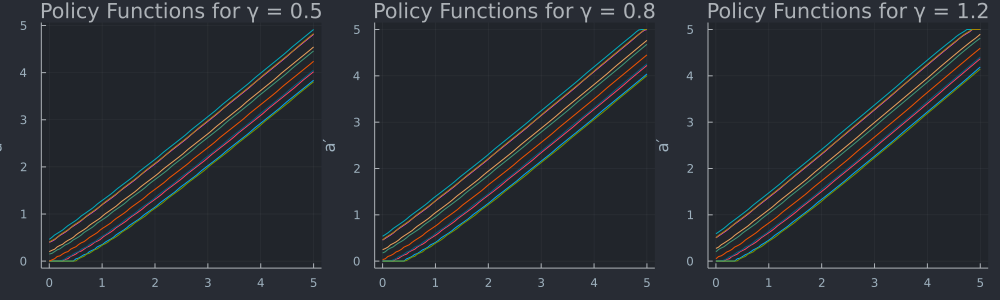

In [127]:
p2 = plot(agrid7, aprime7, xlabel = "a" , ylabel = "a′" , label = false)
p1 = plot(agrid8, aprime8, xlabel = "a" , ylabel = "a′" , label = false)
p3 = plot(agrid9, aprime9, xlabel = "a" , ylabel = "a′" , label = false)
plot(p1, p2, p3, layout = (1, 3), size = (1000, 300), title= ["Policy Functions for γ = 0.5" "Policy Functions for γ = 0.8" "Policy Functions for γ = 1.2"])

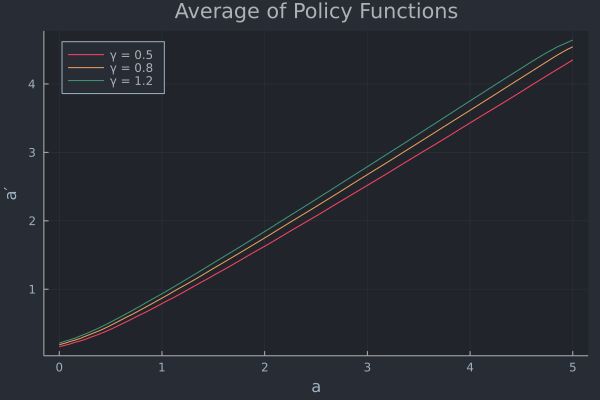

In [128]:
p1 = plot(agrid8, mean(aprime8, dims = 2), label = "γ = 0.5", ylabel = "a′", xlabel = "a")
p1 = plot!(agrid7, mean(aprime7, dims = 2), label = "γ = 0.8", ylabel = "a′", xlabel = "a")
p1 = plot!(agrid9, mean(aprime9, dims = 2), label = "γ = 1.2", ylabel = "a′", xlabel = "a")
plot(p1, layout = (1, 1), size = (600, 400), title= "Average of Policy Functions", legend = :topleft)

با بیشتر شدن گاما درد افراد برای از دست دادن بیشتر می شود و پری کاشنری سیوینگ بالاتر می رود و کروچر بیشتری دارد.

در ستینگ بالا سرعت پایین است و شهود نمودارها هم کمتر است پس سراغ ستینگ زیر میرویم که تنها به یک استیت مسئله را حل میکنند و شهود بهتری هم دارد:

### y, a setting

In [12]:
#the method is value function iteration
function VFI_2(r, # utility function
                h, # productivity function
                shock_distribution, # the distribution of shocks
                y_max, # y in steady state
                N, # nunmber of iterations
                R, # number of grids and shocks
                β) # discount factor
    Random.seed!(1394)
    ζ = rand(shock_distribution, R) # generate shocks
    ygrid = range(10^(-10), y_max, R) 
    Initial_V(y) = y # set initial guess generator function
    V₀ = Initial_V.(ygrid)
    Vⱼ = V₀
    Policy = zeros(R)
    Vⱼ₊₁ = zeros(R)
    g = zeros(R)
    for itr ∈ 1:N
        V = LinearInterpolation(ygrid, Vⱼ[:,end], extrapolation_bc = Line())
        for i ∈ 1:R
            y = ygrid[i]
            Ω(a′) = -(r(y - a′) + β*mean(V(h.(y, a′, ζ))))
            opt = optimize(Ω, 0, y)
            g[i] = opt.minimizer
            Vⱼ₊₁[i] = -Ω(g[i])
        end
        Vⱼ = hcat(Vⱼ, Vⱼ₊₁)
        Vⱼ₊₁ = zeros(R)
    end
    return Vⱼ, g, ygrid
end

VFI_2 (generic function with 1 method)

In [13]:
r(c) = log(c)
h(y, a′, ζ) = (1 + rr)*a′ + ω*ζ

h (generic function with 2 methods)

In [ ]:
r(c) = log(c)
h(y, a′, ζ) = (1 + rr)*a′ + ω*ζ
rr = 0.1
ω = 1
β = 0.93
N = 100
tol = 10^-1
R = 100

V₀, aprime, ygrid = VFI_2(r, # utility function
                h, # productivity function
                Uniform(0, 1), # the distribution of shocks
                y_star, # y in steady state
                100, # nunmber of iterations
                100, # number of grids and shocks
                β)

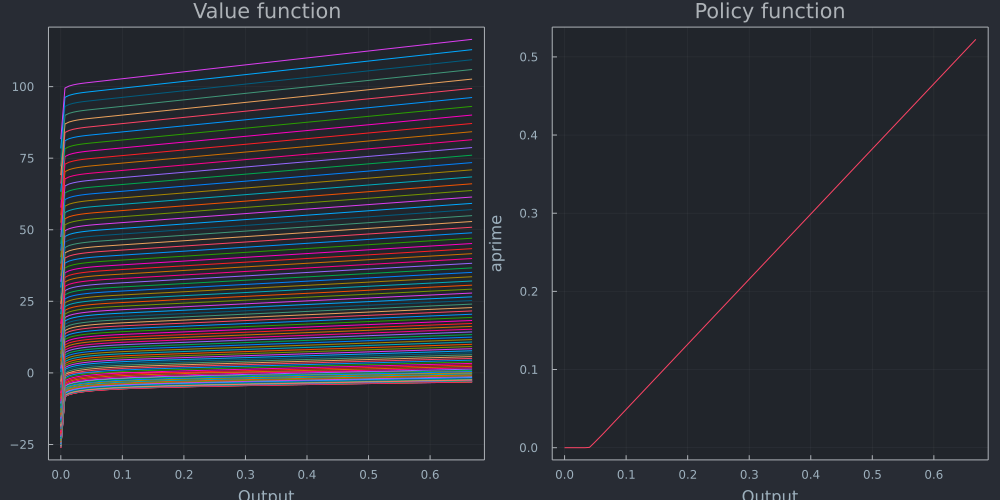

In [15]:
plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(range(0.0, y_star*1.2, 100), V₀, title = "Value function", label = false, xlabel = "Output")
push!(plots, p1)
p2 = plot(range(0.0, y_star*1.2, 100), aprime, title = "Policy function", label = false, ylabel = "aprime", xlabel = "Output")
push!(plots, p2)
plot(plots..., framestyle = :box)

## 2. Plot the policy and value functions for m = 1; 2; 3. How do results depend on the variance m?

In [16]:
rr = 0.1
ω = 1
β = 0.95
N = 100
tol = 10^-1
R = 100
y_max = 5

5

In [22]:
m = 1
σ = 0.5
a, b = mvar_to_ab(m, σ)
V₀1, aprime1, ygrid1 = VFI_2(r, h, Uniform(a, b), y_max, 100, 100, 0.85);

In [23]:
m = 2
σ = 0.5
a, b = mvar_to_ab(m, σ)
V₀2, aprime2, ygrid2 = VFI_2(r, h, Uniform(a, b), y_max, 100, 100, 0.85);

In [27]:
m = 3
σ = 0.5
a, b = mvar_to_ab(m, σ)
V₀3, aprime3, ygrid3 = VFI_2(r, h, Uniform(a, b), y_max, 100, 100, 0.85);

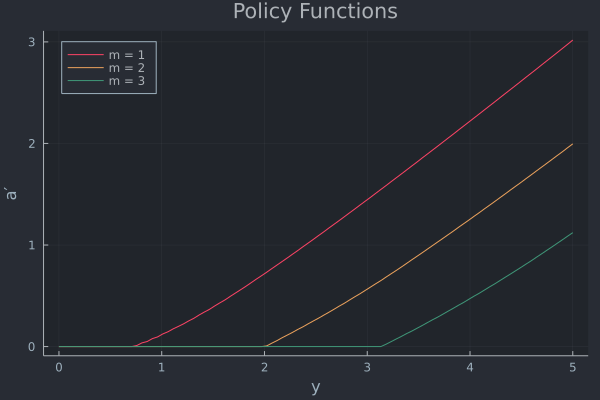

In [28]:
p1 = plot(ygrid1, aprime1, label = "m = 1", ylabel = "a′", xlabel = "y")
p1 = plot!(ygrid2, aprime2, label = "m = 2", ylabel = "a′", xlabel = "y")
p1 = plot!(ygrid3, aprime3, label = "m = 3", ylabel = "a′", xlabel = "y")
plot(p1, layout = (1, 1), size = (600, 400), title= "Policy Functions", legend = :topleft)

با توجه به بیشتر شدن میانگین به علت هموار سازی مصرف، در امد هر دوره بالا می رود و انگار پس انداز کمتر خواهیم داشت.

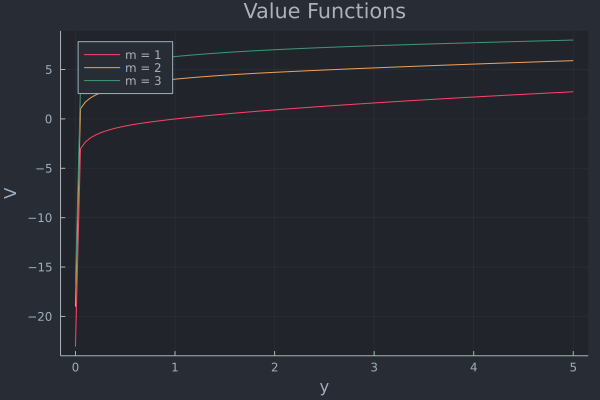

In [29]:
p1 = plot(ygrid1, V₀1[:,end], label = "m = 1", ylabel = "V", xlabel = "y")
p1 = plot!(ygrid2, V₀2[:,end], label = "m = 2", ylabel = "V", xlabel = "y")
p1 = plot!(ygrid3, V₀3[:,end], label = "m = 3", ylabel = "V", xlabel = "y")
plot(p1, layout = (1, 1), size = (600, 400), title= "Value Functions", legend = :topleft)

شهود ما این است که وقتی میانگین وضعیت درامد بهتر می شود باید مطلوبیت هم بیشتر شود که این نمودار مهر تاییدی بر این شهود است.

## 3. Plot the policy and value functions for $\sigma  = .1; .2; .3 $. How do results depend on the variance ? Explain in terms of the precautionary saving. Do we observe it here?

In [43]:
m = 1
σ = 0.1
a, b = mvar_to_ab(m, σ)
V₀4, aprime4, ygrid4 = VFI_2(r, h, Uniform(a, b), y_star, 100, 100, β);

In [44]:
m = 1
σ = 0.4
a, b = mvar_to_ab(m, σ)
V₀5, aprime5, ygrid5 = VFI_2(r, h, Uniform(a, b), y_star, 100, 100, β);

In [45]:
m = 1
σ = 0.7
a, b = mvar_to_ab(m, σ)
V₀6, aprime6, ygrid6 = VFI_2(r, h, Uniform(a, b), y_star, 100, 200, β);

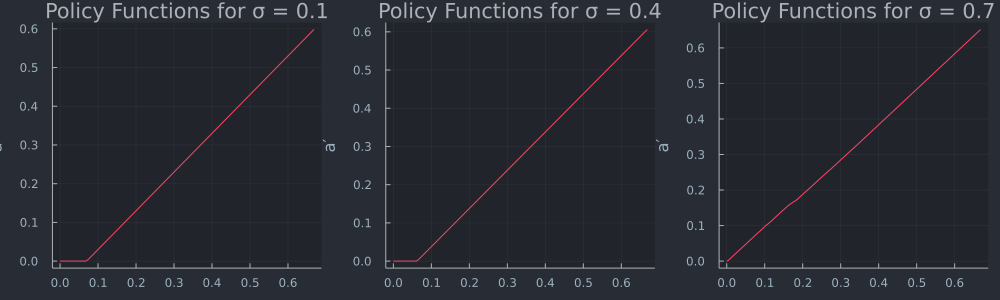

In [46]:
p1 = plot(ygrid4, aprime4, xlabel = "y" , ylabel = "a′" , label = false)
p2 = plot(ygrid5, aprime5, xlabel = "y" , ylabel = "a′" , label = false)
p3 = plot(ygrid6, aprime6, xlabel = "y" , ylabel = "a′" , label = false)
plot(p1, p2, p3, layout = (1, 3), size = (1000, 300), title= ["Policy Functions for σ = 0.1" "Policy Functions for σ = 0.4" "Policy Functions for σ = 0.7"])

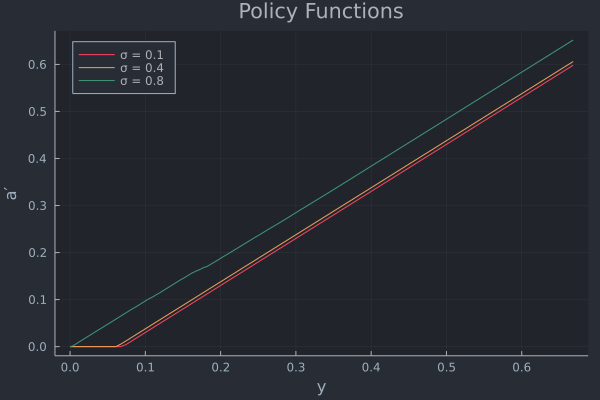

In [56]:
p1 = plot(ygrid4, aprime4, label = "σ = 0.1", ylabel = "a′", xlabel = "y")
p1 = plot!(ygrid5, aprime5, label = "σ = 0.4", ylabel = "a′", xlabel = "y")
p1 = plot!(ygrid6, aprime6, label = "σ = 0.8", ylabel = "a′", xlabel = "y")
plot(p1, layout = (1, 1), size = (600, 400), title= "Policy Functions", legend = :topleft)

مطابق انتظاری که قبلا هم ذکر شد با بیشتر شدن ریسک شوک ها یعنی واریانس آن ها، ما انتظار داریم شاهد پری کاشنری سیوینگ باشیم که دیده شده است در پالیسی فانکشن با بیشتر شدن واریانس مقدار سرمایه گذاری اینده هم بیشتر شده است.

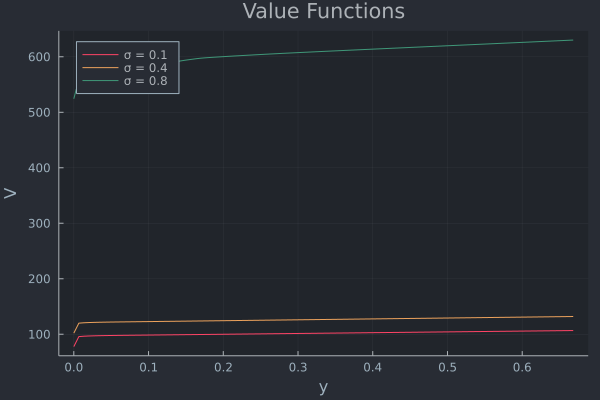

In [67]:
p1 = plot(ygrid4, V₀4[:, end], label = "σ = 0.1", ylabel = "V", xlabel = "y")
p1 = plot!(ygrid5, V₀5[:, end], label = "σ = 0.4", ylabel = "V", xlabel = "y")
p1 = plot!(ygrid6, V₀6[:, end], label = "σ = 0.8", ylabel = "V", xlabel = "y")
plot(p1, layout = (1, 1), size = (600, 400), title= "Value Functions", legend = :topleft)

بیشتر شدن واریانس یعنی مطلوبیت کمتر ما و این هم در نمودار بالا تایید شده است.

## 4. Change the utility function to $ U(c) = \frac {c^{1-\gamma}} {1-\gamma}$ .Show how much the precautionary saving depend on $\gamma$ Explain Intuitively.


In [113]:
rr = 0.15
ω = 1
β = 0.85
N = 100
tol = 10^-1
R = 100

100

In [114]:
U_1(c) = c > 0. ? ((c)^(1 - γ)) / (1 - γ) : 0.

U_1 (generic function with 1 method)

In [115]:
γ = 0.1
m = 2
σ = 0.1
a, b = mvar_to_ab(m, σ)
V₀7, aprime7, ygrid7 = VFI_2(U_1, h, Uniform(a, b), 5, 100, 100, β);

In [116]:
γ = 0.5
m = 2
σ = 0.1
a, b = mvar_to_ab(m, σ)
V₀8, aprime8, ygrid8 = VFI_2(U_1, h, Uniform(a, b), 5, 100, 100, β);

In [117]:
γ = 0.8
m = 2
σ = 0.1
a, b = mvar_to_ab(m, σ)
V₀10, aprime10, ygrid10 = VFI_2(U_1, h, Uniform(a, b), 5, 100, 100, β);

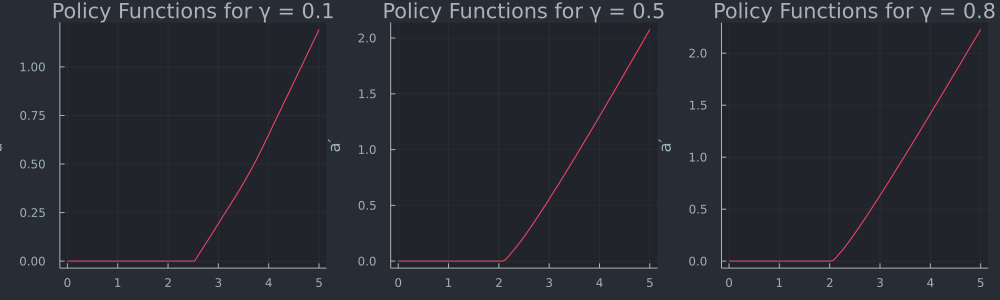

In [118]:
p1 = plot(ygrid7, aprime7, xlabel = "y" , ylabel = "a′" , label = false)
p2 = plot(ygrid8, aprime8, xlabel = "y" , ylabel = "a′" , label = false)
p3 = plot(ygrid10, aprime10, xlabel = "y" , ylabel = "a′" , label = false)
plot(p1, p2, p3, layout = (1, 3), size = (1000, 300), title= ["Policy Functions for γ = 0.1" "Policy Functions for γ = 0.5" "Policy Functions for γ = 0.8"])

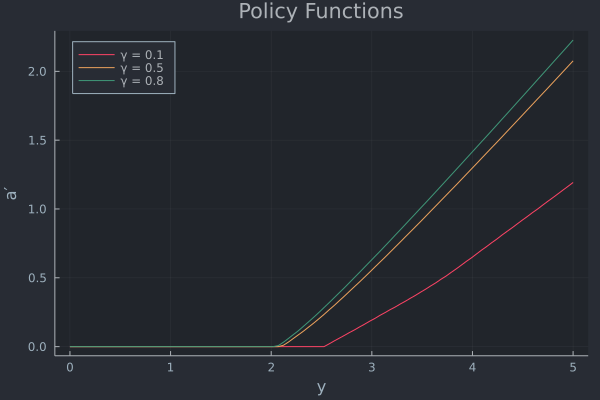

In [119]:
p1 = plot(ygrid7, aprime7, label = "γ = 0.1", ylabel = "a′", xlabel = "y")
p1 = plot!(ygrid8, aprime8, label = "γ = 0.5", ylabel = "a′", xlabel = "y")
p1 = plot!(ygrid10, aprime10, label = "γ = 0.8", ylabel = "a′", xlabel = "y")
plot(p1, layout = (1, 1), size = (600, 400), title= "Policy Functions", legend = :topleft)

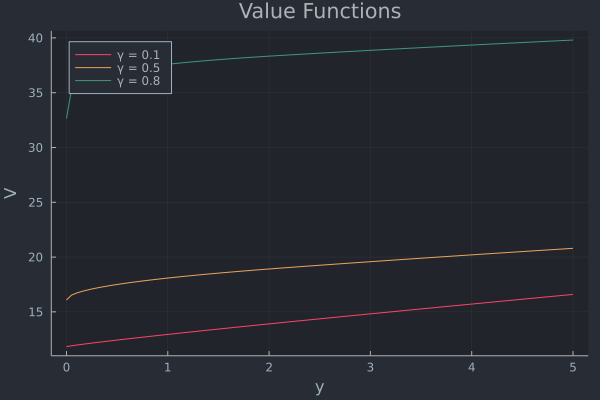

In [120]:
p1 = plot(ygrid7, V₀7[:,end], label = "γ = 0.1", ylabel = "V", xlabel = "y")
p1 = plot!(ygrid8, V₀8[:,end], label = "γ = 0.5", ylabel = "V", xlabel = "y")
p1 = plot!(ygrid10, V₀10[:,end], label = "γ = 0.8", ylabel = "V", xlabel = "y")
plot(p1, layout = (1, 1), size = (600, 400), title= "Value Functions", legend = :topleft)

# 3 LQ DP

In [ ]:
using QuantEcon, LinearAlgebra

## The optimal linear regulator problem:

$$
\begin{aligned}
V(x) &=\max _{\left\{u_{t}\right\}}-\sum_{t=0}^{\infty}\left(x_{t}^{\prime} R x_{t}+u_{t}^{\prime} Q u_{t}\right) \\
\text { s.t. } x_{t+1} &=A x_{t}+B u_{t}
\end{aligned}
$$
- or
$$
V(x)=\max _{u}-\left\{\left(x^{\prime} R x+u^{\prime} Q u\right)+V(A x+B u)\right\}
$$
- Guess:
$$
V(x)=-x^{\prime} P x
$$
- Equivalent to:
$$
-x^{\prime} P x=\max _{u}-\left\{\left(x^{\prime} R x+u^{\prime} Q u\right)-(A x+B u)^{\prime} P(A x+B u)\right\}
$$
Solution
$$
\begin{gathered}
V(x)=-x^{\prime} P x \\
u=-F x \\
F=\left(Q+B^{\prime} P B\right)^{-1} B^{\prime} P A \\
P=R+A^{\prime} P A-A^{\prime} P B\left(Q+B^{\prime} P B\right)^{-1} B^{\prime} P A
\end{gathered}
$$
- Called the Algebraic Matrix Riccatti Equation
- Value function iteration
- Start from $P_{0}=0$
$$
\begin{aligned}
&P_{j+1}=R+A^{\prime} P_{j} A-A^{\prime} P_{j} B\left(Q+B^{\prime} P_{j} B\right)^{-1} B^{\prime} P_{j} A \\
&F_{j+1}=\left(Q+B^{\prime} P_{j} B\right)^{-1} B^{\prime} P_{j} A
\end{aligned}
$$


## Discounted linear regulator problem:


$$
\begin{aligned}
&F=\beta\left(Q+B^{\prime} P B\right)^{-1} B^{\prime} P A \\
&P=R+\beta A^{\prime} P A-\beta^{2} A^{\prime} P B\left(Q+\beta B^{\prime} P B\right)^{-1} B^{\prime} P A
\end{aligned}
$$

## Policy improvement algorithm (Lyapunov):


- Starting from an initial $F_{0}$ for which the eigenvalues of $A-B F_{0}$ are less than $1 / \sqrt{\beta}$ in modulus, the algorithm iterates on the two equations:
$$
\begin{aligned}
P_{j} &=R+F_{j}^{\prime} Q F_{j}-\beta\left(A-B F_{j}\right)^{\prime} P_{j}\left(A-B F_{j}\right) \\
F_{j+1} &=\beta\left(Q+\beta B^{\prime} P_{j} B\right)^{-1} B^{\prime} P_{j} A
\end{aligned}
$$
- This is an example of a discrete Lyapunov or Sylvester equation
$$
P_{j}=\sum_{k=0}^{\infty} \beta^{k}\left(A-B F_{j}\right)^{\prime k}\left(R+F_{j}^{\prime} Q F_{j}\right)\left(A-B F_{j}\right)^{k}
$$
- If the eigenvalues of the matrix $A-B F_{j}$ are bounded in modulus by $1 / \sqrt{\beta}$, then a solution of this equation exists.
- This algorithm is typically much faster than the algorithm that iterates on the matrix Riccati equation.


## The stochastic optimal linear regulator problem:

$$
\begin{aligned}
V(x) &=\max _{\left\{u_{t}\right\}}-E_{0} \sum_{t=0}^{\infty} \beta^{t}\left(x_{t}^{\prime} R x_{t}+u_{t}^{\prime} Q u_{t}\right) \\
\text { s.t. } x_{t+1} &=A x_{t}+B u_{t}+C \varepsilon_{t+1}
\end{aligned}
$$
where $\varepsilon_{t+1}$ is an $(n \times 1)$ vector of random variables that is independently and identically distributed according to the normal distribution with mean vector zero and covariance matrix.
$$
E \varepsilon_{t} \varepsilon_{t}^{\prime}=I
$$
  - Solution
$$
\begin{aligned}
V(x) &=-x^{\prime} P x-d \\
u &=-F x
\end{aligned}
$$
$$
\begin{aligned}
F &=\beta\left(Q+B^{\prime} P B\right)^{-1} B^{\prime} P A \\
P &=R+\beta A^{\prime} P A-\beta^{2} A^{\prime} P B\left(Q+\beta B^{\prime} P B\right)^{-1} B^{\prime} P A \\
d &=\beta(1-\beta)^{-1} \operatorname{tr}\left(P C C^{\prime}\right)
\end{aligned}
$$

In [3]:
#Find an initial guess for F in a way that A-BF is a stable matrix
function IF(β)
    F = rand(Uniform(0, 1), 1, 3)
    while sum(eigvals(A - B * F) .> (1 / √β)) > 0
        F = rand(Uniform(0, 1), 1, 3)
    end
    return F
end

IF (generic function with 1 method)

In [136]:
function LQDP(A, B, R, Q; method = "Riccatti", tol = 10^-5, β = 0.95, shock = false, C = zeros(1, 1))
    dist = 1
    if method == "Riccatti"
        Pⱼ = I(size(A)[1]) #set an intial guess for martix P
        while dist > tol
            Pⱼ₊₁ = R + β * A' * Pⱼ * A - β^2 * A' * Pⱼ * B * ((Q + β * B' * Pⱼ * B)^-1) * B' * Pⱼ * A
            dist = maximum(Pⱼ₊₁ .- Pⱼ)
            Pⱼ = copy(Pⱼ₊₁)
        end
        Fⱼ = β * ((Q + B' * Pⱼ * B)^-1) * B' * Pⱼ * A

    elseif method == "Lyapunov"
        Pⱼ = I(size(A)[1])
        Fⱼ = IF(β)
        P(k) = (β^k)*(((A - B*Fⱼ)')^k)*(R + Fⱼ'*Q*Fⱼ)*(A - B*Fⱼ)^k
        while dist > tol
            Pⱼ₊₁ = P(0)
            k = 1
            while sum(abs.(P(k)) .> 10^-5) > 0
                Pⱼ₊₁ += P(k)
                k += 1
            end
            Fⱼ₊₁ = β*((Q + β*B'*Pⱼ*B)^(-1))*B'*Pⱼ₊₁*A
            dist = maximum(abs.(Fⱼ₊₁ .- Fⱼ))
            Fⱼ = copy(Fⱼ₊₁)
            Pⱼ = copy(Pⱼ₊₁)
        end
    end
    if shock 
        d = β*((1 - β)^-1)*tr(Pⱼ*C*C')
        return Pⱼ, Fⱼ, d
    else
        return Pⱼ, Fⱼ
    end
end

LQDP (generic function with 1 method)

Test this code with the below model and compare it with results from Quantecon:

In [137]:
# model parameters
a0 = 100
a1 = 0.05
β = 0.95
γ = 10.0
# beliefs
κ0 = 95.5
κ1 = 0.95
# formulate the LQ problem
A = [1 0 0
    0 κ1 κ0
    0 0 1]
B = [1.0, 0.0, 0.0]
R = [0 -a1/2 a0/2
    -a1/2 0 0
    a0/2 0 0]
Q = 0.5 * γ

5.0

In [138]:
#Riccati matrix
P_1, F_1 = LQDP(A, B, R, Q; tol = 10^-5, β = 0.95, shock = false, C = zeros(1, 1));
hh_1 = h0_1, h1_1, h2_1 = -F_1[3], 1 - F_1[1], -F_1[2]

lq = QuantEcon.LQ(Q, R, A, B; bet = 0.95)
P_2, F_2 = stationary_values(lq)
hh_2 = h0_2, h1_2, h2_2 = -F_2[3], 1 - F_2[1], -F_2[2];

In [139]:
# Lyapunov
P_3, F_3 = LQDP(A, B, R, Q; method = "Lyapunov", tol = 10^-2, β = 0.95, shock = false, C = zeros(1, 1))
hh_3 = h0_3, h1_3, h2_3 = -F_3[3], 1 - F_3[1], -F_3[2]

(-96.94871793558852, 1.0, 0.04628205127749144)

In [140]:
#compare three methods
[hh_1; hh_2; hh_3]

3-element Vector{Tuple{Float64, Float64, Float64}}:
 (-96.9486818726304, 0.9999999917852563, 0.046282043658138275)
 (-96.94871794872053, 1.0000000000000024, 0.04628205128205243)
 (-96.94871793558852, 1.0, 0.04628205127749144)

# 4 Borrowing Constraint

## Consider the standard borrowing constraint problem of a household who faces i.i.d income shocks and has x = a + e cash at hand:


## 1. Write a Python code to solve for this problem numerically by solving the FOC conditions numerically as explained in the lecture notes.


In [36]:
#the method is value function iteration
function VFI_3(r, # utility function
            h, # productivity function
            el,
            eh,
            π,
            y_max, # y in steady state
            y_min,
            R, # number of grids and shocks
            tol,
            β) # discount factor
    Random.seed!(1394)
    ζ_ = rand(Bernoulli(π), R) # generate shocks
    ζ = map(x -> x == 0 ? el : eh, ζ_) 
    ygrid = range(10^(-10), y_max, R) 
    Initial_V(y) = y # set initial guess generator function
    V₀ = Initial_V.(ygrid)
    Vⱼ = V₀
    Vⱼ₊₁ = zeros(R)
    g = zeros(R)
    dist = 1
    while dist > tol
        V = LinearInterpolation(ygrid, Vⱼ[:, end], extrapolation_bc = Line())
        for i ∈ 1:R
            y = ygrid[i]
            Ω(a′) = -(r(y - (a′/(1+rr))) + β*mean(V(h.(y, a′, ζ))))
            opt = optimize(Ω, y_min, y)
            g[i] = opt.minimizer
            Vⱼ₊₁[i] = -Ω(g[i])
        end
        dist = maximum(abs.(Vⱼ₊₁ .- Vⱼ[:, end]))
        Vⱼ = hcat(Vⱼ, Vⱼ₊₁)
        Vⱼ₊₁ = zeros(R)
    end
    return Vⱼ, g, ygrid
end

VFI_3 (generic function with 2 methods)

In [50]:
γ = 0.8
rr = 0.15
U(c) = c > 0. ? ((c)^(1 - γ)) / (1 - γ) : 0.
h(y, a′, ζ) = a′ + ζ

h (generic function with 1 method)

In [38]:
rr = 0.15
V, c = VFI_3(U, h, 0.5, 1.5, 0.6, 5, -0.25, 500, 10^(-2), 0.85);

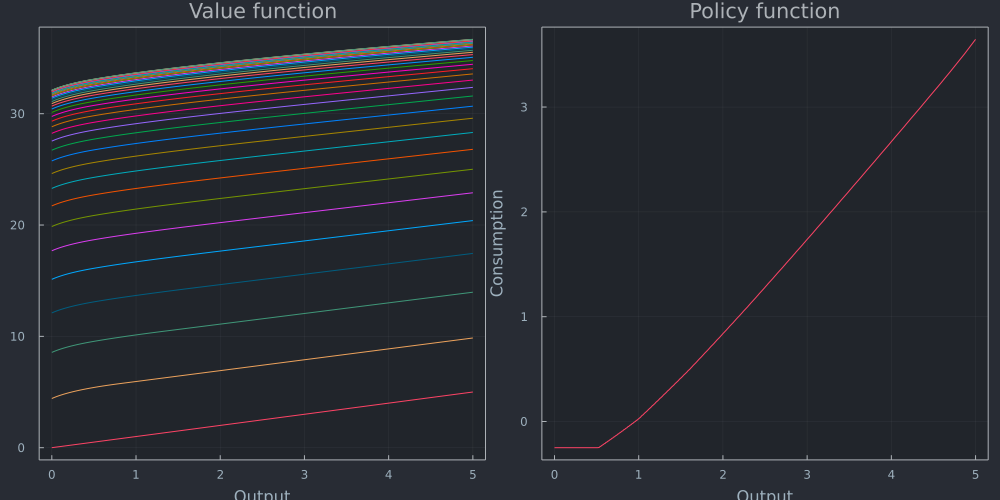

In [39]:

plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(range(0.0, 5, 500), V, title = "Value function", label = false, xlabel = "Output")
push!(plots, p1)
p2 = plot(range(0.0, 5, 500), c, title = "Policy function", label = false, ylabel = "Consumption", xlabel = "Output")
push!(plots, p2)
plot(plots..., framestyle = :box)

## 2. Assume a CRRA preferences and then numerically show how do the HHís optimal decisions change when.

### Changing a_bar:

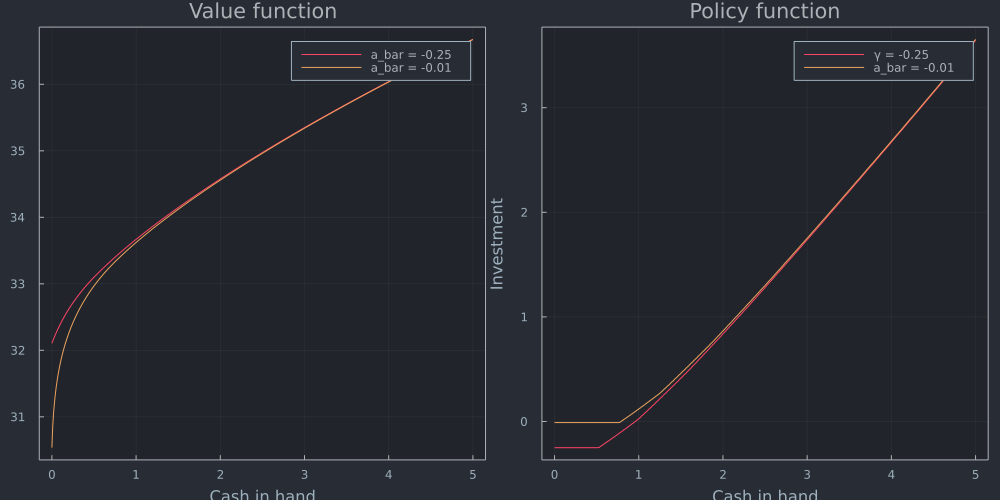

In [53]:
V1, c1 = VFI_3(U, h, 0.5, 1.5, 0.6, 5, -0.01, 500, 10^(-2), 0.85);
plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(range(0.0, 5, 500), V[: , end], title = "Value function", label = "a_bar = -0.25", xlabel = "Cash in hand")
p1 = plot!(range(0.0, 5, 500), V1[: , end], title = "Value function", label = "a_bar = -0.01", xlabel = "Cash in hand")
push!(plots, p1)
p2 = plot(range(0.0, 5, 500), c, title = "Policy function", label = "γ = -0.25", ylabel = "Investment", xlabel = "Cash in hand")
p2 = plot!(range(0.0, 5, 500), c1, title = "Policy function", label = "a_bar = -0.01", ylabel = "Investment", xlabel = "Cash in hand")
push!(plots, p2)
plot(plots..., framestyle = :box)

Intuition:

وقتی ایجنت به حداکثر مقدار وام خود می رسد، دیگر نمی تواند وام بگیرد، بنابراین
تابع پالیسی مسطح می شود. وقتی حداکثر مقداری که او می تواند وام بگیرد را کاهش می دهیم
تابع پالیسی زودتر (در سطح بالاتری از پول نقد در دست) دچار افت می شود و در سطح بالاتری باقی می ماند.
به عبارت دیگر، ایجنت محدودیت بیشتر دارد و به علت محدودیت بیشتر از مقدار خوشحالی و مطلوبیت ایجنت هم کم می شود.

### Changing $\beta$

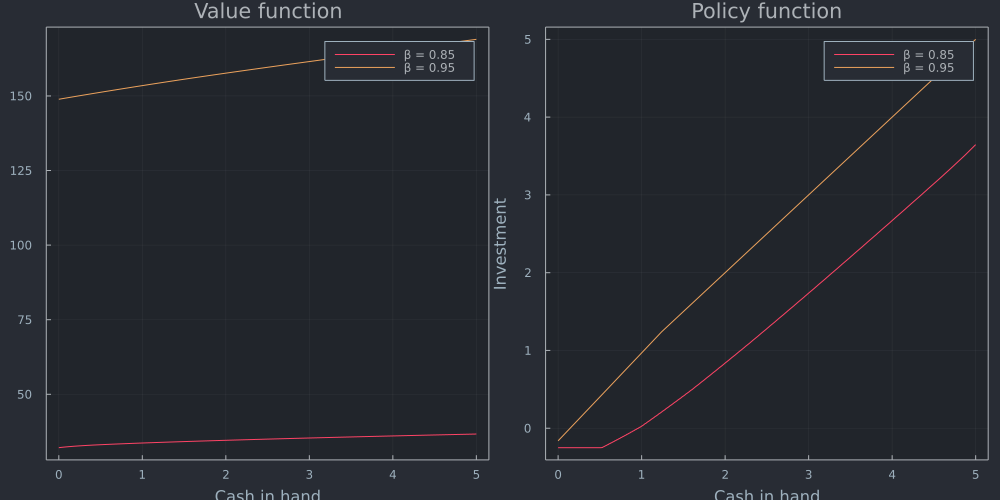

In [47]:
V3, c3 = VFI_3(U, h, 0.5, 1.5, 0.6, 5, -0.25, 500, 10^(-2), 0.95);
plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(range(0.0, 5, 500), V[: , end], title = "Value function", label = "β = 0.85", xlabel = "Cash in hand")
p1 = plot!(range(0.0, 5, 500), V3[: , end], title = "Value function", label = "β = 0.95", xlabel = "Cash in hand")
push!(plots, p1)
p2 = plot(range(0.0, 5, 500), c, title = "Policy function", label = "β = 0.85", ylabel = "Investment", xlabel = "Cash in hand")
p2 = plot!(range(0.0, 5, 500), c3, title = "Policy function", label = "β = 0.95", ylabel = "Investment", xlabel = "Cash in hand")
push!(plots, p2)
plot(plots..., framestyle = :box)

intuition:

با بتای کمتر ایجنت صبر کمتری دارد و به آینده اهمیت کمتری می دهد. در نتیجه صرفه جویی کمتری می کند و هم مطلوبیت بالاتری دارد و هم میزان سرمایه گذاری برای دوره بعد آن کمتر است.

### Changing r:

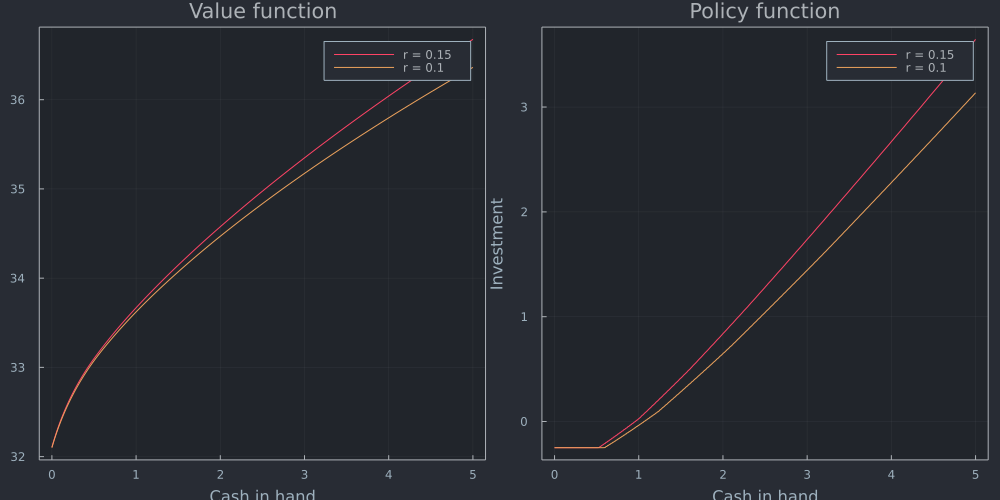

In [49]:
rr = 0.1
V4, c4 = VFI_3(U, h, 0.5, 1.5, 0.6, 5, -0.25, 500, 10^(-2), 0.85);
plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(range(0.0, 5, 500), V[: , end], title = "Value function", label = "r = 0.15", xlabel = "Cash in hand")
p1 = plot!(range(0.0, 5, 500), V4[: , end], title = "Value function", label = "r = 0.1", xlabel = "Cash in hand")
push!(plots, p1)
p2 = plot(range(0.0, 5, 500), c, title = "Policy function", label = "r = 0.15", ylabel = "Investment", xlabel = "Cash in hand")
p2 = plot!(range(0.0, 5, 500), c4, title = "Policy function", label = "r = 0.1", ylabel = "Investment", xlabel = "Cash in hand")
push!(plots, p2)
plot(plots..., framestyle = :box)

intuition:

با بیشتر شدن بازدهی در واقع پاداش پس انداز افزایش می یابد. در نتیجه، ایجنت صرفه جویی بیشتری خواهد کرد. در واقع، او امروز مصرف خود را کاهش می دهد، زیرا پاداش بالاتر در آینده به او سود بیشتری می دهد. باز هم، توابع پالیسی بالا همان چیزی را نشان می دهند که با بیشتر کردن بتا مشاهده می کردیم.

### Changing $\pi$ :

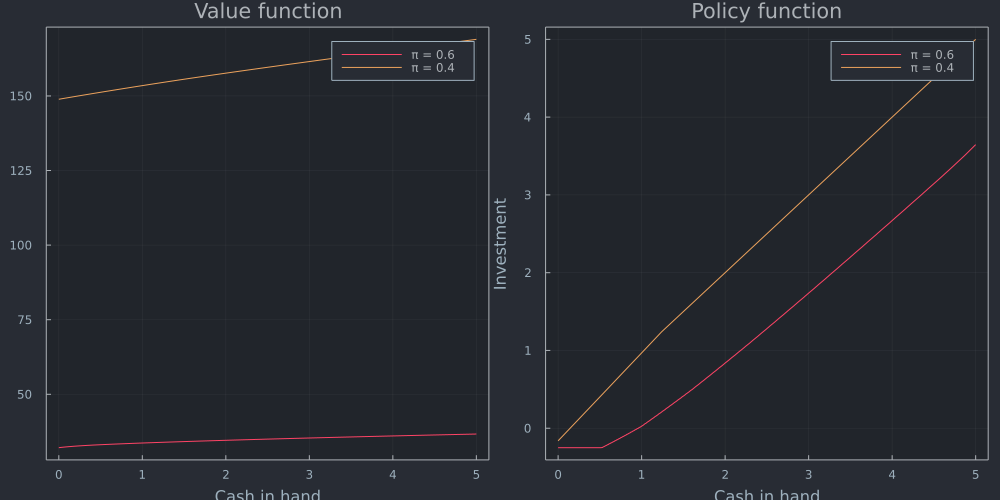

In [51]:
V5, c5 = VFI_3(U, h, 0.5, 1.5, 0.6, 5, -0.25, 500, 10^(-2), 0.95);
plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(range(0.0, 5, 500), V[: , end], title = "Value function", label = "π = 0.6", xlabel = "Cash in hand")
p1 = plot!(range(0.0, 5, 500), V5[: , end], title = "Value function", label = "π = 0.4", xlabel = "Cash in hand")
push!(plots, p1)
p2 = plot(range(0.0, 5, 500), c, title = "Policy function", label = "π = 0.6", ylabel = "Investment", xlabel = "Cash in hand")
p2 = plot!(range(0.0, 5, 500), c5, title = "Policy function", label = "π = 0.4", ylabel = "Investment", xlabel = "Cash in hand")
push!(plots, p2)
plot(plots..., framestyle = :box)

intuition:

با بیشتر شدن احتمال وقوع سطح بالای شوک بدیهتا خوشحالی ما بالاتر خواهد بود و سطح تابع ارزش بالاتر است. از طرفی وقتی احتمال پیامد خوب (درآمد بالاتر) را افزایش می‌دهیم، ارزش مورد انتظار درآمد آتی افزایش می‌یابد و این باعث پس انداز کمتر ما نسبت به احتمال کمتر میشود.. 
 

### Changing E(e):

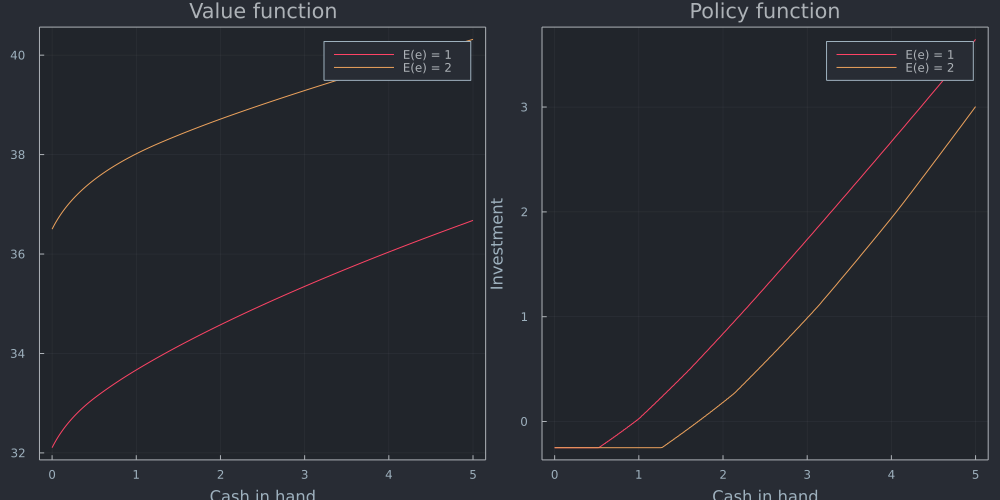

In [52]:
V6, c6 = VFI_3(U, h, 1, 3, 0.6, 5, -0.25, 500, 10^(-2), 0.85);
plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(range(0.0, 5, 500), V[: , end], title = "Value function", label = "E(e) = 1", xlabel = "Cash in hand")
p1 = plot!(range(0.0, 5, 500), V6[: , end], title = "Value function", label = "E(e) = 2", xlabel = "Cash in hand")
push!(plots, p1)
p2 = plot(range(0.0, 5, 500), c, title = "Policy function", label = "E(e) = 1", ylabel = "Investment", xlabel = "Cash in hand")
p2 = plot!(range(0.0, 5, 500), c6, title = "Policy function", label = "E(e) = 2" , ylabel = "Investment", xlabel = "Cash in hand")
push!(plots, p2)
plot(plots..., framestyle = :box)

intuition:

شهود این بخش بسیار شبیه به بخش قبل است. دوباره، ما در حال تغییر وضعیت درآمدی آینده هستیم. مانند افزایش احتمال وقوع پیامد مثبت اینجا هم میانگین شوک های درآمدی ما در آینده بالاتر است پس مطلوبیت و حال ما بالاتر است و از طرفی دغدغه کمتری داریم و کمتر پس انداز می کنیم.

# 5 Convex Adjustment Cost (1)


## 1. Consider a firm with convex adjustment cost.


Consider the first order difference equation fot the state vector:
$$
\left[\begin{array}{l}
y_{t+1} \\
p_{t+1} \\
1
\end{array}\right]=\left[\begin{array}{lll}
1 & 0 & 0 \\
0 & a & 0 \\
0 & 0 & 1
\end{array}\right]\left[\begin{array}{l}
y_{t} \\
p_{t} \\
1
\end{array}\right]+\left[\begin{array}{l}
1 \\
0 \\
0
\end{array}\right]\left(u_{t}\right)+\left[\begin{array}{l}
0 \\
b \\
0
\end{array}\right]\left(\zeta_{t}\right)
$$
where the control $u_{t}$ is given by $\left(y_{t+1}-y_{t}\right)$. The state for the firm's problem is given by $x_{t}^{\prime}=\left[\begin{array}{lll}y_{t} & p_{t} & 1\end{array}\right]$. Having defined $A$ and $B$, we only need to define $Q$ and $R$ (note that the interaction between $u$ and $x$ can be left out here: no $H$ matrix is needed!).
$$
Q=-.5 d ; R=\left[\begin{array}{lll}
0 & -0.5  & 0 \\
-0.5  & 0 & 0 \\
0  & 0 & 0
\end{array}\right]
$$

In [141]:
a = 0.7
b = 0.5 # We can see this parameter as a proxy of shock's variance
d = 2
A = [1 0 0; 0 a 0; 0 0 1]
B = [1; 0; 0]
C = [0; b; 0] # Variance-covariance matrix of shocks
R = [0 0.5 0; 0.5 0 0; 0 0 0]
Q = -0.5*d;

In [142]:
P_4, F_4, d = LQDP(A, B, R, Q; method = "Lyapunov", tol = 10^-5, β = 0.95, shock = true, C = C);

In [143]:
F_4 = round.(F_4, digits = 3)
P_4 = round.(P_4, digits = 3)
d = round(d, digits = 3);

In [145]:
using SymPy

In [170]:
F_4 = round.(F_4, digits = 3)
P_4 = round.(P_4, digits = 3)
@syms yₜ , pₜ
xₜ = [yₜ, pₜ, 1]
x_tr = [[yₜ] [pₜ] [1]]
V = expand((-x_tr*P_5*xₜ)[1])
yₜ₊₁ = yₜ - (F_4*xₜ)[1]
@show V;
@show yₜ₊₁;

V = -0.075*pₜ^2 + 0.512*pₜ*yₜ + 327.442*pₜ - 1069.488*yₜ - 358775.956
yₜ₊₁ = 0.993*pₜ + yₜ


##  (b) Solve for the steady state values as well.

از فرم تابع پالیسی مشخص است که رابطه بین تولید دوره بعد و تولید این دوره خطی است و با بیشتر شدن تولید این دوره طبیعی است شما مایل باشید دوره بعد هم بیشتر تولید کنید. پس این مسئله استدی استیت نخواهد داشت. در واقع عامل محدودیت کننده برای تولید بیشتر در دوره بعد قیمت و تقاضا است و تولید این دوره همواره اثر مثبتی دارد.

## (c) Solve for the Recurisve competitive Equilibrium assuming that the demand curve is linear in terms of p.

a. The Bellman equation corresponding to the firm's problem is given by:
$$
v(y, Y)=\max _{y^{\prime}}\left(A_{0}-A_{1} Y\right) y-.5 d\left(y^{\prime}-y\right)^{2}+\beta v\left(y^{\prime}, Y^{\prime}\right)
$$
where $Y$ evolves according to the farmer's beliefs about the aggregate law of motion:
$$
Y^{\prime}=H_{0}+H_{1} Y
$$


Consider the first order difference equation fot the state vector:
$$
\left[\begin{array}{l}
y_{t+1} \\
Y_{t+1} \\
1
\end{array}\right]=\left[\begin{array}{lll}
1 & 0 & 0 \\
0 & H_{1} & H_{0} \\
0 & 0 & 1
\end{array}\right]\left[\begin{array}{l}
y_{t} \\
Y_{t} \\
1
\end{array}\right]+\left[\begin{array}{l}
1 \\
0 \\
0
\end{array}\right]\left(u_{t}\right)
$$
where the control $u_{t}$ is given by $\left(y_{t+1}-y_{t}\right)$. The state for the firm's problem is given by $x_{t}^{\prime}=\left[\begin{array}{lll}y_{t} & Y_{t} & 1\end{array}\right]$. Having defined $A$ and $B$, we only need to define $Q$ and $R$ (note that the interaction between $u$ and $x$ can be left out here: no $H$ matrix is needed!).
$$
Q=-.5 d ; R=\left[\begin{array}{lll}
0 & -A_{1} / 2 & A_{0} / 2 \\
-A_{1} / 2 & 0 & 0 \\
A_{0} / 2 & 0 & 0
\end{array}\right]
$$

In [155]:
# model parameters
a0 = 100
a1 = 0.05
β = 0.95
γ = 10.0
# beliefs
κ0 = 95.5
κ1 = 0.95
# formulate the LQ problem
A = [1 0 0
    0 κ1 κ0
    0 0 1]
B = [1.0, 0.0, 0.0]
R = [0 -a1/2 a0/2
    -a1/2 0 0
    a0/2 0 0]
Q = -0.5 * γ

-5.0

In [156]:
P_5, F_5 = LQDP(A, B, R, Q; method = "Lyapunov", tol = 10^-5, β = 0.95, shock = false, C = zeros(1, 1))
hh_5 = h0_5, h1_5, h2_5 = -F_5[3], 1 - F_5[1], -F_5[2]

(96.94871794514, 1.0, -0.046282051282051276)

In [166]:
F_5 = round.(F_5, digits = 3)
P_5 = round.(P_5, digits = 3)
@syms yₜ , Yₜ
xₜ = [yₜ, Yₜ, 1]
x_tr = [[yₜ] [Yₜ] [1]]
V = expand((-x_tr*P_5*xₜ)[1])
yₜ₊₁ = yₜ - (F_5*xₜ)[1]

-0.046⋅Yₜ + yₜ + 96.949

In [169]:
@show V;
@show yₜ₊₁;

V = -0.075*Yₜ^2 + 0.512*Yₜ*yₜ + 327.442*Yₜ - 1069.488*yₜ - 358775.956
yₜ₊₁ = -0.046*Yₜ + yₜ + 96.949
